# Building Autoencoders

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from numpy import genfromtxt
from tensorflow.contrib.layers import fully_connected
from sklearn.preprocessing import StandardScaler

%matplotlib inline    

## 1. Load and prepare the data

In [2]:
current_dir = os.getcwd()
## Training data
train_dataset_path = os.path.join(os.getcwd(), os.pardir,'data','small_higgs.csv')
higgs_train = genfromtxt(train_dataset_path, delimiter=',')
X_low_level_features = higgs_train[:,1:22]
#X_high_level_features = higgs_train[:,22:]
#y_train = higgs_train[:,0]
del higgs_train

## 2. Build the input pipepline

In [3]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(X_low_level_features)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)
iterator = train_dataset.make_initializable_iterator()
next_element = iterator.get_next()

## 3. Build a function containing the NN

In this implementation, we must make sure that the weights to and from the central hidden layer (the one containing the codings) are "tied".

Because of the architechture of the Autoencoder we will build this NN using the TensorFlow core.

In [4]:
n_inputs = 21 # this is the number of low-level features in our dataset
n_hidden1 = 12
n_hidden2 = 4  # this is the number of "codings" we want to extract
n_hidden3 = n_hidden1
n_outputs = n_inputs

def Autoencoder(inputs):
    initializer = tf.contrib.layers.variance_scaling_initializer(seed=25)
    w1_init = initializer([n_inputs, n_hidden1])
    w2_init = initializer([n_hidden1, n_hidden2])
    # Weights 
    w1 = tf.Variable(w1_init, dtype=tf.float32, name="weights1")
    w2 = tf.Variable(w2_init, dtype=tf.float32, name="weights2")
    # these should be the same as above or "tied weights"
    w3 = tf.transpose(w2, name="weights3")  
    w4 = tf.transpose(w1, name="weights4")
    # Biases
    b1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
    b2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
    b3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
    b4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

    ## Neural Network
    hidden1 = tf.nn.relu(tf.matmul(inputs, w1) + b1)
    codings = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
    hidden3 = tf.nn.relu(tf.matmul(codings, w3) + b3)
    outputs = tf.matmul(hidden3, w4) + b4
    return codings, outputs

## 4. Create a placeholder to pass values for training

In [5]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

## 5. Define the loss 

In [6]:
codings, X_out = Autoencoder(X)
loss = tf.reduce_mean(tf.square(X_out - X)) # also known as reconstruction loss

## 6. Define the optimizer and training operation

In [7]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

## 7. (Optional) Write a function for running the training operation

In [8]:
def train_model(epoch_number):
    if epoch_number%10==0:
        print(epoch_number, end=',')
    iterator.initializer.run()
    while True:
        try:
            X_values = sess.run(next_element)
            sess.run(training_op, feed_dict={X: X_values})
        except tf.errors.OutOfRangeError:
            break

## 8. Run the computation graph

In [9]:
N_EPOCHS = 300
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print("Epoch: ")
    for epoch in range(1,N_EPOCHS+1):
        train_model(epoch)
    print("\nDone Training!")
    resulting_codings, X_out = sess.run([codings, X_out], feed_dict={X: X_low_level_features})

Epoch: 
10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,
Done Training!


## 9. Visualize/analyze the results

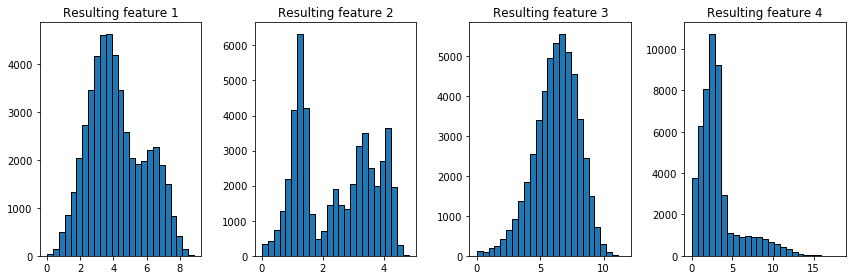

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i in range(4):
    p = axes.flatten()[i]
    p.hist(resulting_codings[:,i], bins=25, ec='black')
    p.set_title('Resulting feature ' + str(i+1))
    plt.tight_layout();